## Load the Dataset

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
# Load the dataset

df = pd.read_csv('Cleaned_Data.csv')
df.head()

,Location,Price,Rooms,Bathrooms,Property Type,Size,Furnishing,Store Rooms,Places of Worship,Schools,Hospitals,Malls,Restaurants
0,KLCC,1250000.0000,2,3.0000,Serviced Residence,1335.0000,Fully Furnished,1,53.0000,24.0000,20.0000,5.0000,818.0000
1,KLCC,2400000.0000,2,2.0000,Serviced Residence,1006.0000,Fully Furnished,0,53.0000,24.0000,20.0000,5.0000,818.0000
2,KLCC,3600000.0000,4,4.0000,Serviced Residence,3897.0000,Partly Furnished,0,53.0000,24.0000,20.0000,5.0000,818.0000
3,KLCC,4280000.0000,3,4.0000,Serviced Residence,2195.0000,Fully Furnished,1,53.0000,24.0000,20.0000,5.0000,818.0000
4,KLCC,2300000.0000,1,2.0000,Serviced Residence,1023.0000,Partly Furnished,0,53.0000,24.0000,20.0000,5.0000,818.0000


## Data Pre-processing

### Encoding

In [3]:
# Select categorical columns

categorical = df.select_dtypes(exclude=[np.number]).columns
print (categorical)

Index(['Location', 'Property Type', 'Furnishing'], dtype='object')


In [4]:
# Encode Location

le_location = LabelEncoder()
df['Location'] = le_location.fit_transform(df['Location'])

In [5]:
# Encode Property Type

le_proptype = LabelEncoder()
df['Property Type'] = le_proptype.fit_transform(df['Property Type'])

In [6]:
# Encode Furnishing

le_furnishing = LabelEncoder()
df['Furnishing'] = le_furnishing.fit_transform(df['Furnishing'])

### Split and Scale the Dataset

In [7]:
# Shuffle rows

df = shuffle(df, random_state=42)

In [8]:
# Split dataset into features and outcome

DV = 'Price'
x = df.drop(DV, axis=1)
y = df[DV]

In [9]:
# Split into train and test

x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.20,
random_state=42)

In [40]:
# Select all numerical columns except for Price

numerical = ['Rooms', 'Bathrooms', 'Size', 'Store Rooms', 'Places of Worship',\
             'Schools', 'Hospitals', 'Malls', 'Restaurants']

In [44]:
# Scale numerical columns in x_train

scaler = MinMaxScaler()
x_train_scaled = x_train.copy()
x_train_scaled[numerical] = scaler.fit_transform(x_train_scaled[numerical])
x_train_scaled.head()

,Location,Rooms,Bathrooms,Property Type,Size,Furnishing,Store Rooms,Places of Worship,Schools,Hospitals,Malls,Restaurants
36520,0,0.3333,0.3333,2,0.3248,0,0.5000,0.7692,0.9286,0.8261,1.0000,0.9078
1863,32,0.1667,0.1667,6,0.2287,0,0.5000,0.9744,0.7857,0.8696,0.6250,0.8133
18650,25,0.3333,0.3333,7,0.2638,2,0.5000,0.5641,0.7500,0.0435,0.6250,0.5456
43497,60,0.3333,0.1667,6,0.1358,0,0.0000,1.0000,0.6429,0.9130,0.6250,0.8078
34544,14,0.6667,0.6667,5,0.6737,1,1.0000,0.2564,0.2857,0.0435,0.1250,0.0622


In [45]:
# Scale numerical columns in x_test

x_test_scaled = x_test.copy()
x_test_scaled[numerical] = scaler.transform(x_test_scaled[numerical])
x_test_scaled.head()

,Location,Rooms,Bathrooms,Property Type,Size,Furnishing,Store Rooms,Places of Worship,Schools,Hospitals,Malls,Restaurants
41944,51,0.5000,0.6667,2,0.7418,0,0.5000,0.5641,0.5357,0.2609,0.3750,0.4422
22395,49,0.3333,0.1667,6,0.1204,2,0.0000,0.8205,0.4643,1.0000,0.2500,0.4367
14960,20,0.5000,0.6667,5,0.8796,2,0.5000,0.1795,0.1429,0.1739,0.1250,0.1633
41012,12,0.3333,0.3333,2,0.4303,1,0.5000,0.5641,0.6607,0.1739,0.5000,0.4733
36204,0,0.3333,0.3333,6,0.1642,0,0.0000,0.7692,0.9286,0.8261,1.0000,0.9078


## Modelling

In [10]:
# Define function to calculate adjusted r-squared

def calculate_adjusted_r_squared(y_test, pred):
    r_squared = r2_score(y_test, pred)
    n = len(y_test)
    adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - 12 - 1)
    return adjusted_r_squared

### XGBoost

# Find metrics for default XGBoost model

from sklearn import metrics

default_XGB = XGBRegressor(random_state=42)
default_XGB.fit(x_train, y_train)
pred = default_XGB.predict(x_test)
default_XGB_metrics = pd.DataFrame ({'Metric':
['MAE', 'MSE', 'RMSE', 'R-Squared', 'Adjusted R-Squared'],
'Default XGBoost':
[metrics.mean_absolute_error(y_test, pred),
metrics.mean_squared_error (y_test, pred),
np.sqrt (metrics.mean_squared_error (y_test, pred)),
metrics.explained_variance_score (y_test, pred),
calculate_adjusted_r_squared(y_test, pred)]})
default_XGB_metrics

In [12]:
# Grid Search for XGBoost 

XGB = XGBRegressor(random_state=42)

param_grid = {'nthread':[4], 
              'objective':['reg:squarederror'],
              'learning_rate': [0.03, 0.05, 0.07], 
              'max_depth': [10, 15, 20],
              'min_child_weight': [1, 3, 5],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100, 300, 500]}

XGB_model = model_selection.GridSearchCV(
estimator=XGB,
param_grid=param_grid,
verbose=True,
n_jobs=-1,
cv=3
)

XGB_model.fit(x_train, y_train)
print(f"Best score: {XGB_model.best_score_}")
print("Best parameters set:")
best_parameters = XGB_model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best score: 0.9022117064318039
Best parameters set:
	colsample_bytree: 0.7
	learning_rate: 0.03
	max_depth: 20
	min_child_weight: 5
	n_estimators: 300
	nthread: 4
	objective: reg:squarederror
	subsample: 0.7


In [11]:
# Build XGBoost model

XGB_model = XGBRegressor(
    random_state=42,
    colsample_bytree=0.7,
    learning_rate=0.03,
    max_depth=20,
    min_child_weight=3,
    n_estimators=300,
    nthread=4,
    objective='reg:squarederror',
    subsample=0.7
)

XGB_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, nthread=4, num_parallel_tree=None,
             predictor=None, ...)

In [12]:
# Generate predictions

pred = XGB_model.predict(x_test)
print(pred[:10])

[3127056.8   487548.12 2440627.8  1541732.   1108894.1   595956.4
  470577.7   555266.3  2477899.    673547.25]


In [13]:
# Find metrics
from sklearn import metrics

XGB_metrics = pd.DataFrame ({'Metric':
['MAE', 'MSE', 'RMSE', 'R-Squared', 'Adjusted R-Squared'],
'XGBoost':
[metrics.mean_absolute_error(y_test, pred),
metrics.mean_squared_error (y_test, pred),
np.sqrt (metrics.mean_squared_error (y_test, pred)),
metrics.explained_variance_score (y_test, pred),
calculate_adjusted_r_squared(y_test, pred)]})
XGB_metrics

,Metric,XGBoost
0,MAE,149424.2175
1,MSE,97550719843.5257
2,RMSE,312331.1061
3,R-Squared,0.9098
4,Adjusted R-Squared,0.9097


### Random Forest

# Find metrics for default RF model

from sklearn import metrics

default_RF = RandomForestRegressor(random_state=42)
default_RF.fit(x_train, y_train)
pred = default_RF.predict(x_test)
default_RF_metrics = pd.DataFrame ({'Metric':
['MAE', 'MSE', 'RMSE', 'R-Squared', 'Adjusted R-Squared'],
'Default RF':
[metrics.mean_absolute_error(y_test, pred),
metrics.mean_squared_error (y_test, pred),
np.sqrt (metrics.mean_squared_error (y_test, pred)),
metrics.explained_variance_score (y_test, pred),
calculate_adjusted_r_squared(y_test, pred)]})
default_RF_metrics

In [28]:
# Grid Search for Random Forest

RF = RandomForestRegressor(random_state=42)

param_grid = {
"n_estimators": [200, 500, 1000],
'max_features': [4, 7, 10],
"max_depth": [50, 100],
'min_samples_leaf': [1, 3],
'min_samples_split': [5, 10]
}

RF_model = model_selection.GridSearchCV(
estimator=RF,
param_grid=param_grid,
verbose=10,
n_jobs=-1,
cv=3
)

RF_model.fit(x_train, y_train)
print(f"Best score: {RF_model.best_score_}")
print("Best parameters set:")
best_parameters = RF_model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best score: 0.8942403812066204
Best parameters set:
	max_depth: 50
	max_features: 10
	min_samples_leaf: 1
	min_samples_split: 5
	n_estimators: 1000


In [14]:
# Build Random Forest model

RF_model = RandomForestRegressor(
    random_state=42,
    max_depth=50,
    max_features=10,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=1000
)
RF_model.fit(x_train,y_train)

RandomForestRegressor(max_depth=50, max_features=10, min_samples_split=5,
                      n_estimators=1000, random_state=42)

In [15]:
# Generate predictions

pred = RF_model.predict(x_test)
print(pred[:10])

[3165489.58763168  492430.16109142 2695433.90745876 1586437.40650794
 1113056.56612579  621444.75349928  473654.38751804  566820.63954379
 2484410.16583836  654860.04601991]


In [16]:
# Find metrics
from sklearn import metrics

RF_metrics = pd.DataFrame ({'Metric':
['MAE', 'MSE', 'RMSE', 'R-Squared', 'Adjusted R-Squared'],
'Random Forest':
[metrics.mean_absolute_error(y_test, pred),
metrics.mean_squared_error (y_test, pred),
np.sqrt (metrics.mean_squared_error (y_test, pred)),
metrics.explained_variance_score (y_test, pred),
calculate_adjusted_r_squared(y_test, pred)]})
RF_metrics

,Metric,Random Forest
0,MAE,154187.0439
1,MSE,105672943224.3387
2,RMSE,325073.7504
3,R-Squared,0.9023
4,Adjusted R-Squared,0.9022


### Decision Tree

In [18]:
# GridSearch for Decision Tree

DT = DecisionTreeRegressor()

param_grid = {
"max_depth": [2, 4, 6, 8, 10],
"splitter": ["best", "random"],
"criterion": ["squared_error", "absolute_error"],
"max_features": ["auto", "sqrt", "log2", None]
}

DT_model = model_selection.GridSearchCV(
estimator=DT,
param_grid=param_grid,
verbose=10,
n_jobs=-1,
cv=3
)

DT_model.fit(x_train, y_train)
print(f"Best score: {DT_model.best_score_}")
print("Best parameters set:")
best_parameters = DT_model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best score: 0.8240447828348008
Best parameters set:
	criterion: squared_error
	max_depth: 10
	max_features: auto
	splitter: best


C:\Users\Gan Kai Feng\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


In [22]:
DT_model = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=10,
    max_features='auto',
    splitter='best',
)
DT_model.fit(x_train, y_train)

C:\Users\Gan Kai Feng\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


DecisionTreeRegressor(max_depth=10, max_features='auto')

In [24]:
# Generate predictions

pred = DT_model.predict(x_test)
print(pred[:10])

[3146474.57090909  574733.90745856 3221551.0989011  1731086.03603604
  935310.88732394  679302.54936709  692479.29770992  511174.01383485
 3624194.47163121  574733.90745856]


In [25]:
# Find metrics
from sklearn import metrics

DT_metrics = pd.DataFrame ({'Metric':
['MAE', 'MSE', 'RMSE', 'R-Squared', 'Adjusted R-Squared'],
'Decision Tree':
[metrics.mean_absolute_error(y_test, pred),
metrics.mean_squared_error (y_test, pred),
np.sqrt (metrics.mean_squared_error (y_test, pred)),
metrics.explained_variance_score (y_test, pred),
calculate_adjusted_r_squared(y_test, pred)]})
DT_metrics

,Metric,Decision Tree
0,MAE,233739.9501
1,MSE,185184300267.2620
2,RMSE,430330.4547
3,R-Squared,0.8288
4,Adjusted R-Squared,0.8286


## Model Evaluation

In [33]:
# Set the color palette to 'rocket_r'
rocket_colors = sns.color_palette('rocket_r')

# Select the color at index 4
col = [rocket_colors[1], rocket_colors[3], rocket_colors[5]]

In [27]:
# Create dataframe for XGBoost, RF and DT metrics

metrics = pd.merge(XGB_metrics, RF_metrics, on='Metric', how='inner')
metrics = pd.merge(metrics, DT_metrics, on='Metric', how='inner')
metrics.set_index('Metric', inplace=True)
metrics = metrics.round(4)
metrics

,XGBoost,Random Forest,Decision Tree
Metric,,,
MAE,149424.2175,154187.0439,233739.9501
MSE,97550719843.5257,105672943224.3387,185184300267.2620
RMSE,312331.1061,325073.7504,430330.4547
R-Squared,0.9098,0.9023,0.8288
Adjusted R-Squared,0.9097,0.9022,0.8286


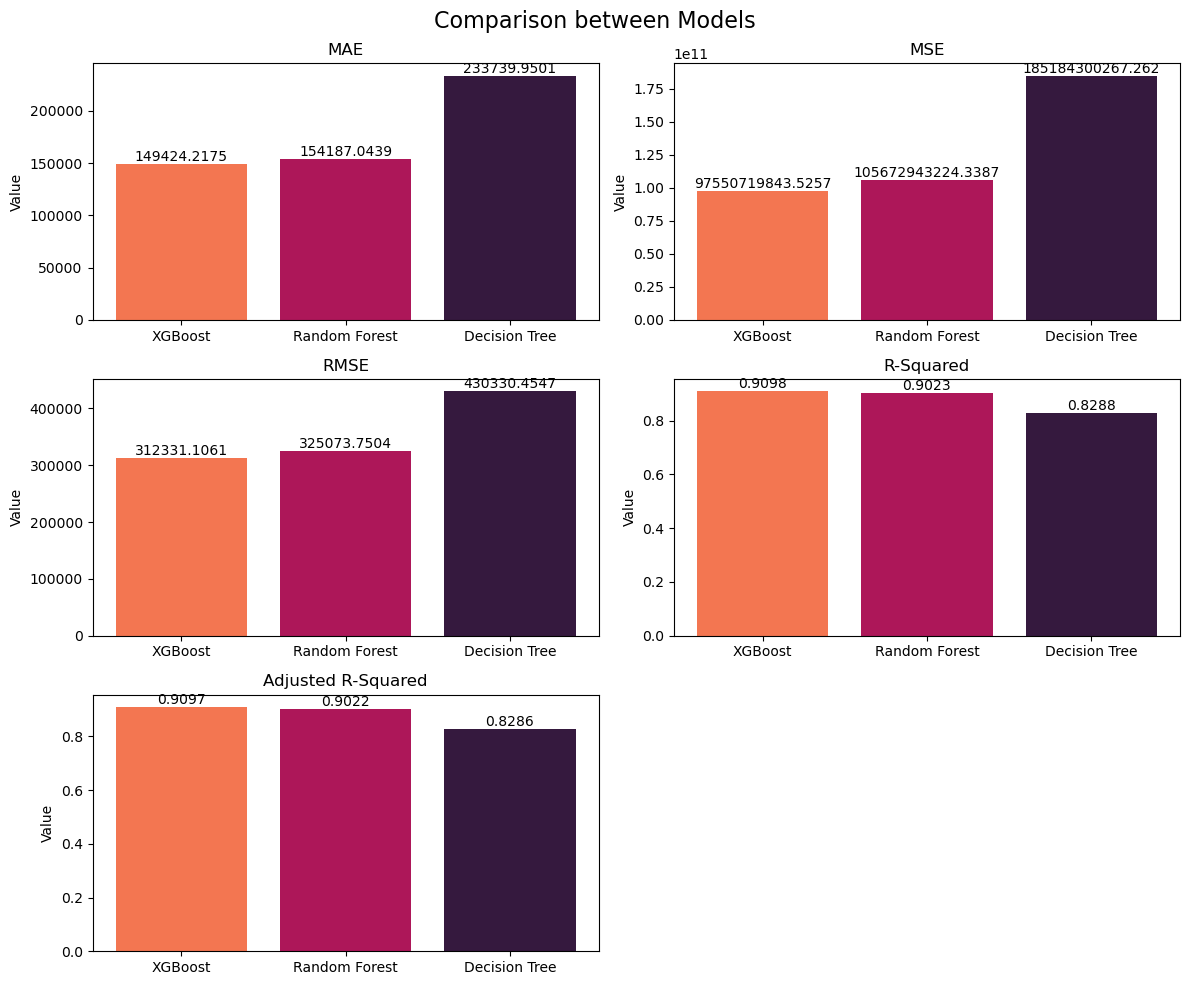

In [34]:
# Plotting the five metrics using subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Set the overall title
fig.suptitle('Comparison between Models', fontsize=16)

# Plot MAE
axes[0, 0].bar(metrics.columns, metrics.loc['MAE'], color=col)
axes[0, 0].set_title('MAE')
axes[0, 0].set_ylabel('Value')
for i, v in enumerate(metrics.loc['MAE']):
    axes[0, 0].text(i, v, str(v), ha='center', va='bottom')

# Plot MSE
axes[0, 1].bar(metrics.columns, metrics.loc['MSE'], color=col)
axes[0, 1].set_title('MSE')
axes[0, 1].set_ylabel('Value')
for i, v in enumerate(metrics.loc['MSE']):
    axes[0, 1].text(i, v, str(v), ha='center', va='bottom')

# Plot RMSE
axes[1, 0].bar(metrics.columns, metrics.loc['RMSE'], color=col)
axes[1, 0].set_title('RMSE')
axes[1, 0].set_ylabel('Value')
for i, v in enumerate(metrics.loc['RMSE']):
    axes[1, 0].text(i, v, str(v), ha='center', va='bottom')

# Plot R-Squared
axes[1, 1].bar(metrics.columns, metrics.loc['R-Squared'], color=col)
axes[1, 1].set_title('R-Squared')
axes[1, 1].set_ylabel('Value')
for i, v in enumerate(metrics.loc['R-Squared']):
    axes[1, 1].text(i, v, str(v), ha='center', va='bottom')
    
# Plot Adjusted R-Squared
axes[2, 0].bar(metrics.columns, metrics.loc['Adjusted R-Squared'], color=col)
axes[2, 0].set_title('Adjusted R-Squared')
axes[2, 0].set_ylabel('Value')
for i, v in enumerate(metrics.loc['Adjusted R-Squared']):
    axes[2, 0].text(i, v, str(v), ha='center', va='bottom')
    
# Remove empty subplot
fig.delaxes(axes[2, 1])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

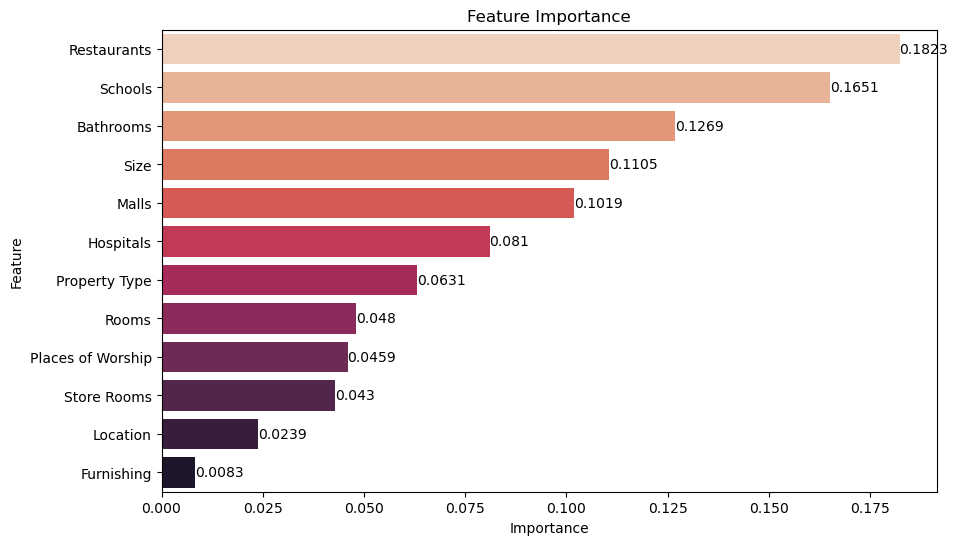

In [35]:
# Get the feature importance scores from the trained XGBoost model
feature_importance = XGB_model.feature_importances_

# Get the names of the columns from your dataset
column_names = ['Location', 'Rooms', 'Bathrooms', 'Property Type',\
                'Size', 'Furnishing', 'Store Rooms', 'Places of Worship',\
                'Schools', 'Hospitals', 'Malls', 'Restaurants']

# Create a DataFrame to store the feature importance scores along with the column names
feature_importance_df = pd.DataFrame({'Feature': column_names, 'Importance': feature_importance})

# Sort the DataFrame in descending order of importance scores
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='rocket_r')
for i, v in enumerate(feature_importance_df['Importance']):
    plt.text(v, i, str(round(v, 4)), va='center')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [36]:
# Save XGBoost model and Label Encoders

joblib.dump(XGB_model, 'model')
joblib.dump(le_location, 'le_location')
joblib.dump(le_proptype, 'le_proptype')
joblib.dump(le_furnishing, 'le_furnishing')

['le_furnishing']

In [ ]:
#data = {
    #'model': XGB_model,
    #'le_location': le_location,
    #'le_proptype': le_proptype,
    #'le_furnishing': le_furnishing
#}

#with open('saved_steps.pkl', 'wb') as file:
    #pickle.dump(data, file)